## Problem 1

In [4]:
import math
import numpy as np
import kplr
import matplotlib.pyplot as plt 
%matplotlib inline

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
f.close()


In [5]:
fulltime = hdu_data["time"] # get the time of each observation
fullflux = hdu_data["sap_flux"] # get the flux
fullflux_err = hdu_data["sap_flux_err"] # get the error in the flux

In [6]:
import my_transit

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - my_transit.delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    return I(r) * 2 * r

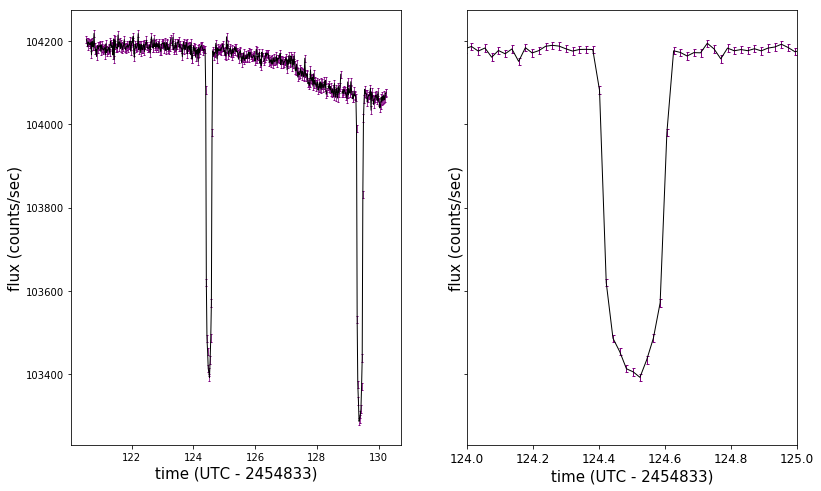

In [10]:
# plot flux vs time, 124 < t < 125 

f, axarr = plt.subplots(1, 2,figsize=(13,8), sharey=True)
axarr[0].errorbar(fulltime,fullflux,yerr=fullflux_err,color="black",ecolor="purple",lw=1,elinewidth=0.75,capsize=1)
axarr[0].set_xlabel("time (UTC - 2454833)", fontsize = 15)
axarr[0].set_ylabel("flux (counts/sec)", fontsize = 15)
axarr[1].errorbar(fulltime,fullflux,yerr=fullflux_err,color="black",ecolor="purple",lw=1,elinewidth=1,capsize=1.5)
axarr[1].set_xlabel("time (UTC - 2454833)", fontsize = 15)
axarr[1].set_ylabel("flux (counts/sec)", fontsize = 15)
axarr[1].set_xlim(124,125)
plt.tick_params(labelsize=12)

In [11]:
# extract data from 124 < t < 125

extraction = np.where((fulltime > 124)&(fulltime < 125))
time = fulltime[extraction] 
flux = fullflux[extraction]
flux_err = fullflux_err[extraction]


In [12]:
"""to compare flux from kepler data and fluxratio we must find avg unobscured flux and divide kepler flux by this.
we will implement a two-sigma clipping algorithm """

def two_sigma(a_flux):
    iteration = 1 
    while iteration < 6:
        avg_flux = np.mean(a_flux)
        std = np.std(a_flux)
        norm = (np.abs(a_flux - avg_flux)/std)
        where = np.where(norm > 2) # find values more than 2 sigma away
        a_flux = np.delete(a_flux,where) # delete these values, update flux array 
        iteration = iteration + 1 
    return np.mean(a_flux) # return mean of final flux values after 5 iterations 

final_mean = two_sigma(flux)
norm_flux = flux / final_mean
norm_error = flux_err / final_mean


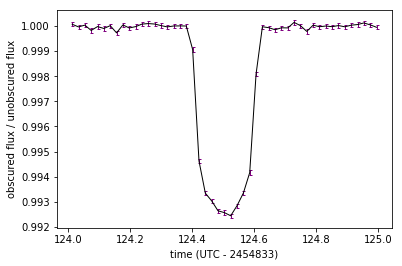

In [13]:
# normalized plot 
plt.errorbar(time,norm_flux,yerr=norm_error,color="black",ecolor="purple",lw=1,elinewidth=1,capsize=1.5)
plt.xlabel("time (UTC - 2454833)")
plt.ylabel("obscured flux / unobscured flux")

In [14]:
"""now we will go ahead with model fitting using the function F in pset 2. we are given values for the parameters. 
we will use scipy to integrate"""
# z = (t - t0) / tau
# tau is related to duration of eclipse 
# t0 is time of maximal eclipse 
# p is ratio between the radius of the planet and radius of the star 

p1 = 0.0775
tau1 = 0.1
t01 = 124.51 

# first, let's make quick function to go from t to z
def z_t(tau,t0):
    return abs((time - t0) / tau)
z_list1 = z_t(tau1,t01)


# scipy integrate returns two values, the integration and the abs error of the integral 
# iterate points across zlist 
def integrate(z,p):
    from scipy import integrate
    flux_model = []
    abs_error = []
    for i in z:
        flux_model = flux_model + [integrate.quad(func1,0,1,args=(p,i))[0] / integrate.quad(func2,0,1,args=(p,i))[0]]
        abs_error = abs_error + [integrate.quad(func1,0,1,args=(p,i))[1] / integrate.quad(func2,0,1,args=(p,i))[1]]
    return flux_model,abs_error
    
flux_model = integrate(z_list1,p1)[0]
abs_error = integrate(z_list1,p1)[1]

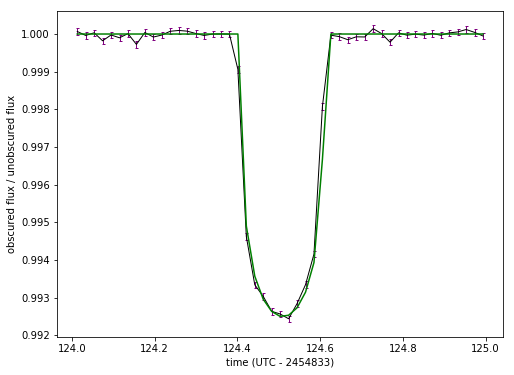

In [15]:
plt.figure(figsize=(8,6))
plt.errorbar(time,norm_flux,yerr=norm_error,color="black",ecolor="purple",lw=1,elinewidth=1,capsize=1.5,zorder=2)
plt.errorbar(time,flux_model,color="green",elinewidth=1,capsize=1.5)
plt.xlabel("time (UTC - 2454833)")
plt.ylabel("obscured flux / unobscured flux")

In [16]:
# let's calculate chi squared

def chi2(F_i, F_model, error_Fi):
    return np.sum(((F_i - F_model) / error_Fi)**2)

In [17]:
chi2(norm_flux,flux_model,norm_error)

465.19869242056228

## Problem 2

In [18]:
"""is this a good fit by your eye? 
yes. when looking at it (and for pset 3) I thought this was an excellent fit"""

'is this a good fit by your eye? \nyes. when looking at it (and for pset 3) I thought this was an excellent fit'

In [19]:
# calculate p value for this fit, aka probability of getting this chi2 by chance
# from lecture 10, q value (or p value) is the gamma function with a=v/2 and x=chi^2/2 
# import gamma function from scipy 

def q_value(N,M,chi):
    # N is number of data points (49)
    # M is number of parameters (3)
    from scipy import special 
    v = N - M 
    return special.gammaincc(v/2,(chi)/2) 

q_value(49,3,465)

1.2023445315423245e-70

In [20]:
"""oh no! this is a very low p value. when p is small, the model is either wrong, the measurement errors are larger than stated,  or they are not normally distributed. in this case, since we are trusting our data, the model is probably really wrong. which is surprising because I thought it was a good fit."""

'oh no! this is a very low p value. \nwhen p is small, the model is either wrong, the measurement errors are larger than stated, \nor they are not normally distributed. in this case, since we are trusting our data, the model is probably really wrong.\nwhich is surprising because I thought it was a good fit.'

## Problem 3

In [21]:
varying_taus = np.linspace(0.08,0.131,100)
list_zs = ([z_t(i,t01) for i in varying_taus])
fluxs = [integrate(i,p1)[0] for i in list_zs]
errors = [integrate(i,p1)[1] for i in list_zs]
chi_squares = [(chi2(norm_flux,i,norm_error)) for i in fluxs]

In [22]:
min_chi2 = min(chi_squares)
print(min_chi2)
index_of_min = np.where(chi_squares == min_chi2)
# print(index_of_min[0][0])
best_fluxes = fluxs[index_of_min[0][0]]
best_errors = errors[index_of_min[0][0]]
# print(best_fluxes)
best_tau = varying_taus[index_of_min[0]]
print("best fitting tau value = ", best_tau)

247.385162729
best fitting tau value =  [ 0.097]


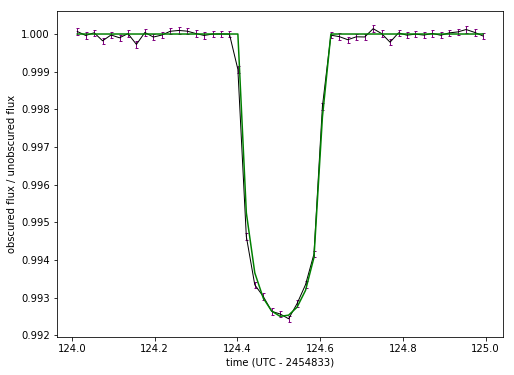

In [23]:
plt.figure(figsize=(8,6))
plt.errorbar(time,norm_flux,yerr=norm_error,color="black",ecolor="purple",lw=1,elinewidth=1,capsize=1.5,zorder=2)
plt.errorbar(time,best_fluxes,color="green")
plt.xlabel("time (UTC - 2454833)")
plt.ylabel("obscured flux / unobscured flux")

In [24]:
q_value(49,3,min_chi2)

"""this is a better p value! but still pretty bad """

'this is a better p value! but still pretty bad '

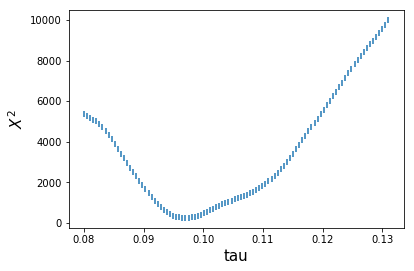

In [25]:
plt.scatter(varying_taus,chi_squares,marker="|")
plt.xlabel("tau",size="15")
plt.ylabel("$X^2$",size="15")

one sigma uncertainty of tau is from 0.09689 to 0.09706


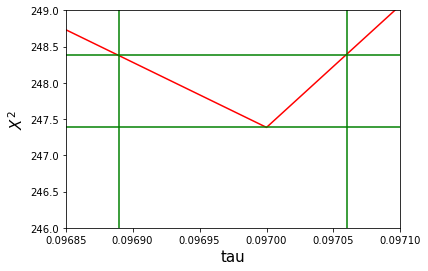

In [26]:
# determine one-sigma uncertainty in this parameter from the chi squared plot
# find + 1 from the minimum chi2
plt.plot(varying_taus,chi_squares,color="red")
plt.xlabel("tau",size="15")
plt.ylabel("$X^2$",size="15")
plt.xlim(0.09685,0.0971)
plt.ylim(246, 249)
plt.axhline(y=(min_chi2+1),color="green")
plt.axhline(y=(min_chi2),color="green")
plt.axvline(x=(0.09689),color="green")
plt.axvline(x=(0.09706),color="green")

print("one sigma uncertainty of tau is from 0.09689 to 0.09706")

## Problem 4

In [ ]:
# implementing an mcmc using emcee 

In [27]:
def logposterior(theta,time,norm_flux,flux_error):
    # create logposterior function to use for MCMC 
    tau, t0, p  = theta
    # make top hat function
    low_tau = 0  # lower limit for tau
    high_tau = 0.999  # upper limit for tau
    low_t0 = 124
    high_t0 = 125 
    low_p = 0.00001 
    high_p = 0.9999 
    
    # if parameters are within priors, calculate likelihood
    if ((low_tau < tau) & (tau < high_tau)) & ((low_t0 < t0) & (t0 < high_t0)) & ((low_p < p) & (p < high_p)):
        logpi = 0  # tophat
        z = z_t(tau,t0)
        F_model = integrate(z,p)[0]
        loglike = -np.sum(.05*np.log(2*np.pi)) - np.sum(np.log(norm_error)) - 0.5*chi2(norm_flux, F_model, norm_error)
        return loglike + logpi
    
    # if outside priors, posterior is large negative number
    else:
        logpi = -np.inf
        return logpi

In [29]:
ndim, nwalkers = 3, 6
initial = best_tau[0], t01, p1
pos = np.asarray([initial + 1e-4*np.random.randn(ndim) for i in range(nwalkers)])
print(pos.shape)

(6, 3)


In [30]:
pos

array([[  9.70404674e-02,   1.24510061e+02,   7.74961643e-02],
       [  9.70005491e-02,   1.24509986e+02,   7.75416890e-02],
       [  9.69825739e-02,   1.24510022e+02,   7.74813378e-02],
       [  9.71105175e-02,   1.24510078e+02,   7.75380706e-02],
       [  9.69171468e-02,   1.24510202e+02,   7.77684185e-02],
       [  9.71336582e-02,   1.24510044e+02,   7.73959094e-02]])

In [31]:
import emcee

In [32]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(time, norm_flux, norm_error))
sampler.run_mcmc(pos, 500)

(array([[  1.01019963e-01,   1.24505409e+02,   7.73949704e-02],
        [  1.01130176e-01,   1.24505260e+02,   7.71880430e-02],
        [  1.00904031e-01,   1.24505245e+02,   7.73075451e-02],
        [  1.01384925e-01,   1.24505021e+02,   7.70827034e-02],
        [  1.00569672e-01,   1.24505327e+02,   7.71141349e-02],
        [  1.00948078e-01,   1.24505354e+02,   7.73007743e-02]]),
 array([ 431.20117667,  432.24271407,  431.57263632,  430.65962411,
         427.72654347,  431.72375254]),
 ('MT19937', array([3157831008, 3799467355, 3216390754, 2349845576, 3780614436,
         1622752084,  669316331,  605039867, 1324967820, 1442797156,
         1156995291,  292274593, 2900458124, 2969095973,  941580047,
         2749201632, 3416028141, 2222143537, 2787662767, 1029558464,
          951808524, 3615051103, 1912012575, 2568487494,  104870450,
         1429278461, 3931445484, 4214689346, 1945219976, 3898849048,
         2646265271, 2174393910, 1347650623, 4103893625, 1743954409,
         205

In [36]:
sampler.chain.shape

(6, 500, 3)

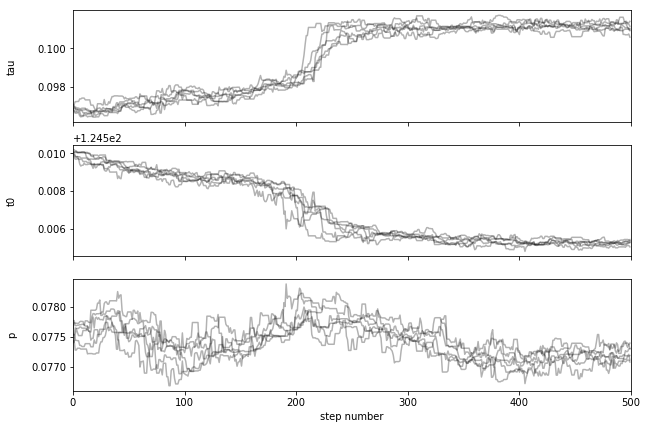

In [38]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["tau", "t0", "p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, 500)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# these chains look good, p good converge a bit better 

In [67]:
# cut off chains at 250 
cutsamples = samples[:, 250:, :]

# merge all 6 walkers
cutsamples = np.reshape(cutsamples, (1500,3))

In [66]:
best_parameters = np.mean(cutsamples, axis=0)
parameters_uncertainties = np.std(cutsamples, axis=0)
print("best tau, t0, and p =", best_parameters)
print("uncertainties for tau, t0, and p =", parameters_uncertainties)

best tau, t0, and p = [  1.01084855e-01   1.24505402e+02   7.72987332e-02]
uncertainties for tau, t0, and p = [ 0.00023484  0.00026034  0.00024861]


In [63]:
mcmc_z = z_t(best_parameters[0],best_parameters[1])
mcmc_flux = integrate(p=best_parameters[2],z=mcmc_z)[0]

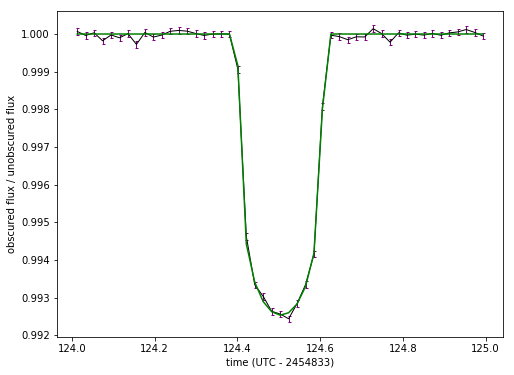

In [64]:
plt.figure(figsize=(8,6))
plt.errorbar(time,norm_flux,yerr=norm_error,color="black",ecolor="purple",lw=1,elinewidth=1,capsize=1.5,zorder=2)
plt.errorbar(time,mcmc_flux,color="green")
plt.xlabel("time (UTC - 2454833)")
plt.ylabel("obscured flux / unobscured flux")

In [72]:
# let's calculate the chi2 for these best fit parameters! 
mcmc_chi2 = chi2(norm_flux,mcmc_flux,norm_error)
mcmc_p = q_value(49,3,mcmc_chi2)

print("chi squared = ", mcmc_chi2)
print("p value = ", mcmc_p)

# a much better fit! although still not perfect!

chi squared =  54.3806566231
p value =  0.185587711108
